In [1]:
# !pip install datasets transformers huggingface_hub
# !apt-get install git-lfs
# !pip install accelerate -U
# !pip install transformers[torch]
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install evaluate
# !pip install transformers

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

import torch
torch.cuda.is_available()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ciri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv("IMDB Dataset.csv",sep=",")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
#Dataset balance
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

positive    25000
negative    25000
Name: sentiment, dtype: int64


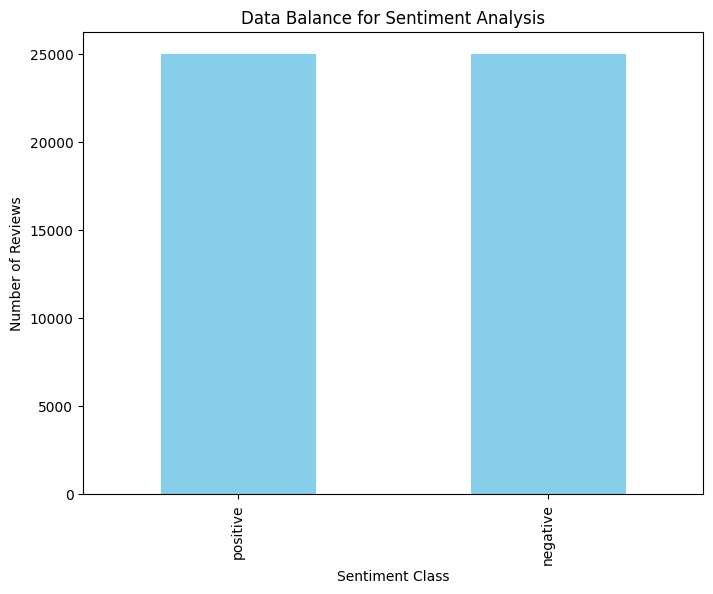

In [4]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Data Balance for Sentiment Analysis')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.show()

In [6]:
df = df.drop_duplicates()

In [7]:
#Checking if there are nulls
print("Checking for NULLs:")
df.isnull().any() 

Checking for NULLs:


review       False
sentiment    False
dtype: bool

In [9]:
#lowercasing
df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

In [10]:
#Removing unnecessary symbols
df["review"] = df["review"].str.replace('[^a-zA-Z0-9 ]','')
df["review"] = df["review"].str.replace('br','')
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1})
df

C:\Users\Ciri\AppData\Local\Temp\ipykernel_25960\4232374258.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["review"] = df["review"].str.replace('[^a-zA-Z0-9 ]','')


,review,sentiment
0,one of the other reviewers has mentioned that ...,0
1,a wonderful little production the filming te...,0
2,i thought this was a wonderful way to spend ti...,0
3,basically theres a family where a little boy j...,1
4,petter matteis love in the time of money is a ...,0
...,...,...
49995,i thought this movie did a down right good job...,0
49996,bad plot bad dialogue bad acting idiotic direc...,1
49997,i am a catholic taught in parochial elementary...,1
49998,im going to have to disagree with the previous...,1


In [11]:
subset = df.iloc[0:3300]

## Preparations

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers.optimization import get_scheduler
from sklearn.model_selection import train_test_split
from datasets import load_metric
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix
from transformers import pipeline
import evaluate

In [12]:
#function that tokenizes text and returns it as dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

In [13]:
#Train test split
docs, labels = subset["review"].tolist(), subset["sentiment"].tolist()
X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.2, random_state=42)

In [14]:
bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

train_docs_dataset = Dataset(bert_tokenizer, X_train, y_train)
eval_docs_dataset = Dataset(bert_tokenizer, X_test, y_test)

batch_size = 8
epochs = 2

weight_decay = 0.01

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.we

In [15]:
#Defying metrics and training arguments
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    #########################################
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}
    #########################################

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    auto_find_batch_size=True,
    evaluation_strategy="epoch",
    weight_decay=weight_decay,
    logging_dir='./logs'
)

## Training the model

In [16]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_docs_dataset,
    eval_dataset=eval_docs_dataset,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()
trainer.evaluate()
trainer.save_model("./distilbert_model")

## Testing the model with new data

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("./distilbert_model")

df_pred = df.iloc[3301:4301] #Data that hasn't been used before
X_pred = df_pred["review"].tolist()
y_real = df_pred["sentiment"].to_list()

tokenized_input = bert_tokenizer(X_pred, padding=True, truncation=True, return_tensors="pt", max_length=128)

with torch.no_grad():
    outputs = model(**tokenized_input)

predicted_probs = torch.softmax(outputs.logits, dim=1)[:, 1].tolist()  # Counting probability for the 'positive' class

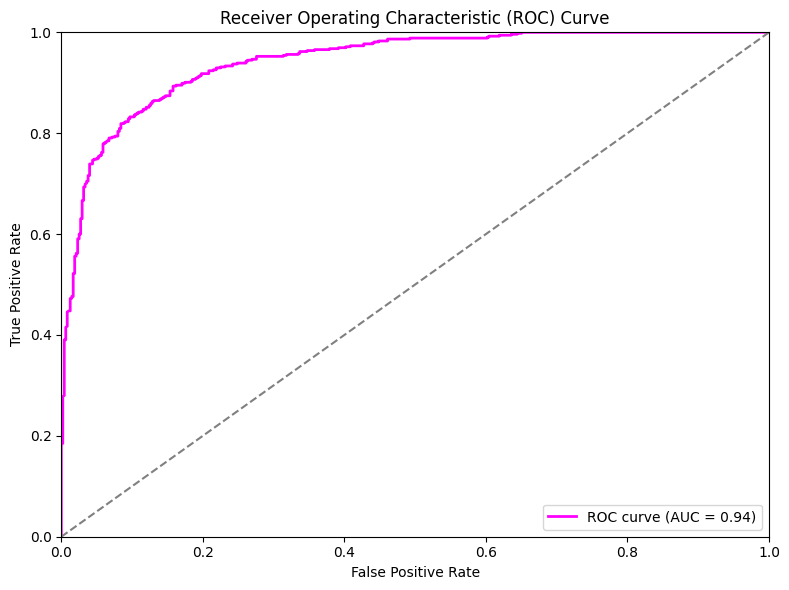

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


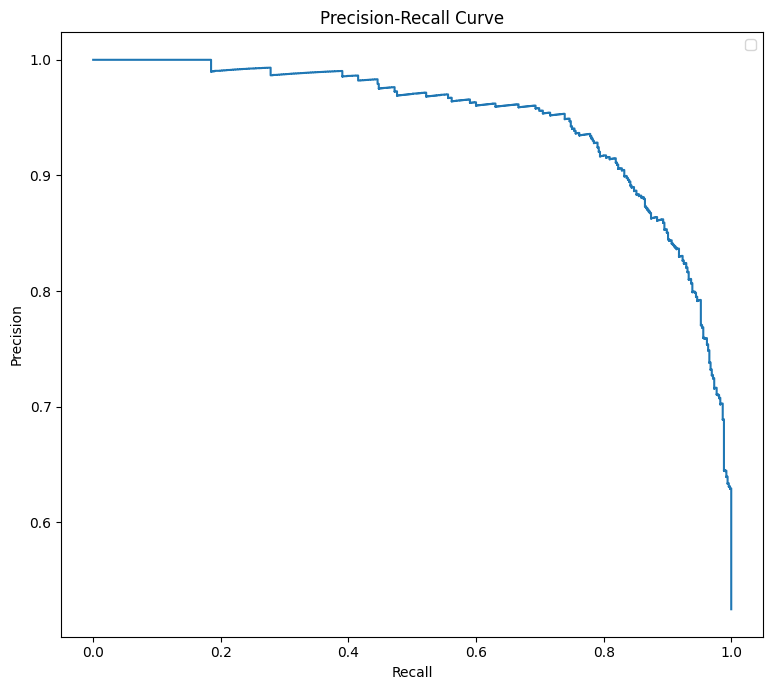

In [18]:
#Plotting ROC and Precision-Recall curves
fpr, tpr, thresholds = roc_curve(y_real, predicted_probs)
auc = roc_auc_score(y_real, predicted_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='magenta', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_real, predicted_probs)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [25]:
threshold = 0.5
y_pred = [1 if prob >= threshold else 0 for prob in predicted_probs]

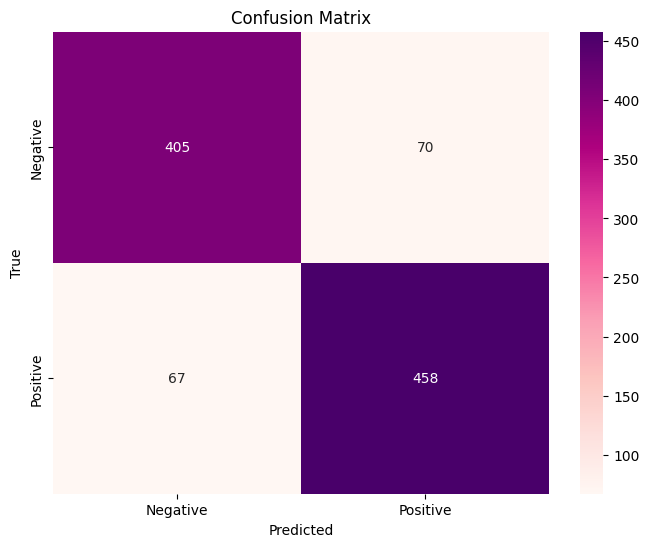

In [31]:
#confusion matrix
import seaborn as sns

cm = confusion_matrix(y_real, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()